In [34]:
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore")

############################################ Lecture des fichiers ######################################
##################################### Préparation et analyse des données ###############################

mobilisation = pd.read_csv("LFB Mobilisation data Last 3 years.csv", header=0, sep=";");
incident = pd.read_csv("LFB Incident data Last 3 years.csv", header=0, sep=";");

df_merge = pd.merge(incident, mobilisation, on='IncidentNumber')
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 587073 entries, 0 to 587072
Data columns (total 59 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   IncidentNumber                          587073 non-null  object 
 1   DateOfCall                              587073 non-null  object 
 2   CalYear_x                               587073 non-null  int64  
 3   TimeOfCall                              587073 non-null  object 
 4   HourOfCall_x                            587073 non-null  int64  
 5   IncidentGroup                           587073 non-null  object 
 6   StopCodeDescription                     587073 non-null  object 
 7   SpecialServiceType                      125417 non-null  object 
 8   PropertyCategory                        587073 non-null  object 
 9   PropertyType                            587073 non-null  object 
 10  AddressQualifier                        5870

In [35]:
#On contrôle le pourcentage de valeurs manquantes
print(df_merge.isna().sum()/len(df_merge)*100)

# On supprime les variables qui ont plus de 50% de valeurs manquantes et qui représente
# un intérêt mineur pour l'apprentissage du modele et pour l'intérprétation du résulat final.
# On fait une exception pour la variable SpecialServiceType qui sera re-travaillée plus tard
df_merge = df_merge.drop(["Postcode_full", "Easting_m", "Northing_m", "Latitude", "Longitude", "DelayCodeId", "DelayCode_Description","DateAndTimeReturned"], axis = 1)

#### On scinde le dataset en 2 groupes ####
#### Variables indicatrices et categorielles ####
df_indicatrice = df_merge.select_dtypes(include=['int64','float64'])
df_categorielle = df_merge.select_dtypes(include=['object'])

print(df_indicatrice.info())
print(df_categorielle.info())

IncidentNumber                              0.000000
DateOfCall                                  0.000000
CalYear_x                                   0.000000
TimeOfCall                                  0.000000
HourOfCall_x                                0.000000
IncidentGroup                               0.000000
StopCodeDescription                         0.000000
SpecialServiceType                         78.636899
PropertyCategory                            0.000000
PropertyType                                0.000000
AddressQualifier                            0.000000
Postcode_full                              58.263793
Postcode_district                           0.000000
UPRN                                        0.000000
USRN                                        0.000000
IncGeo_BoroughCode                          0.000000
IncGeo_BoroughName                          0.000000
ProperCase                                  0.000000
IncGeo_WardCode                             0.

In [36]:
# La variable IncidentNumber ne représente pas de notion métier donc peu influente sur
# l'aprentissage et sur l'analyse du résultat final
df_categorielle = df_categorielle.drop("IncidentNumber", axis = 1)
df_categorielle.columns

Index(['DateOfCall', 'TimeOfCall', 'IncidentGroup', 'StopCodeDescription',
       'SpecialServiceType', 'PropertyCategory', 'PropertyType',
       'AddressQualifier', 'Postcode_district', 'UPRN', 'IncGeo_BoroughCode',
       'IncGeo_BoroughName', 'ProperCase', 'IncGeo_WardCode',
       'IncGeo_WardName', 'IncGeo_WardNameNew', 'FRS', 'IncidentStationGround',
       'FirstPumpArriving_DeployedFromStation',
       'SecondPumpArriving_DeployedFromStation', 'Resource_Code',
       'PerformanceReporting', 'DateAndTimeMobilised', 'DateAndTimeMobile',
       'DateAndTimeArrived', 'DateAndTimeLeft', 'DeployedFromStation_Code',
       'DeployedFromStation_Name', 'DeployedFromLocation', 'PlusCode_Code',
       'PlusCode_Description'],
      dtype='object')

In [5]:
# On regarde les valeurs pour analyse
df_categorielle.sample()

,DateOfCall,TimeOfCall,IncidentGroup,StopCodeDescription,SpecialServiceType,PropertyCategory,PropertyType,AddressQualifier,Postcode_district,UPRN,...,PerformanceReporting,DateAndTimeMobilised,DateAndTimeMobile,DateAndTimeArrived,DateAndTimeLeft,DeployedFromStation_Code,DeployedFromStation_Name,DeployedFromLocation,PlusCode_Code,PlusCode_Description
556716,28 Aug 2021,03:00:10,Special Service,Special Service,Flooding,Dwelling,House - single occupancy,Correct incident location,TW7,0,...,1,28/08/2021 02:00:10,28/08/2021 02:02:21,28/08/2021 02:04:40,28/08/2021 02:36:55,G38,Heston,Home Station,Initial,Initial Mobilisation


In [37]:
# On supprime les notions de date et heures en doublon pour ne conserver que celles utiles
# pour l'appretissage du modèle et pour l'intérprétation du résultat final
# On conserve les variables DateAndTimeMobilised et DateAndTimeArrived pour faire 
# une intérprétation sur le délai d'intervention du résultat final 
df_categorielle = df_categorielle.drop(['DateOfCall','TimeOfCall', 'DateAndTimeMobile', 'DateAndTimeLeft'], axis = 1)


Text(0.5, 1.0, 'Nombre de valeurs unique par colonne :')

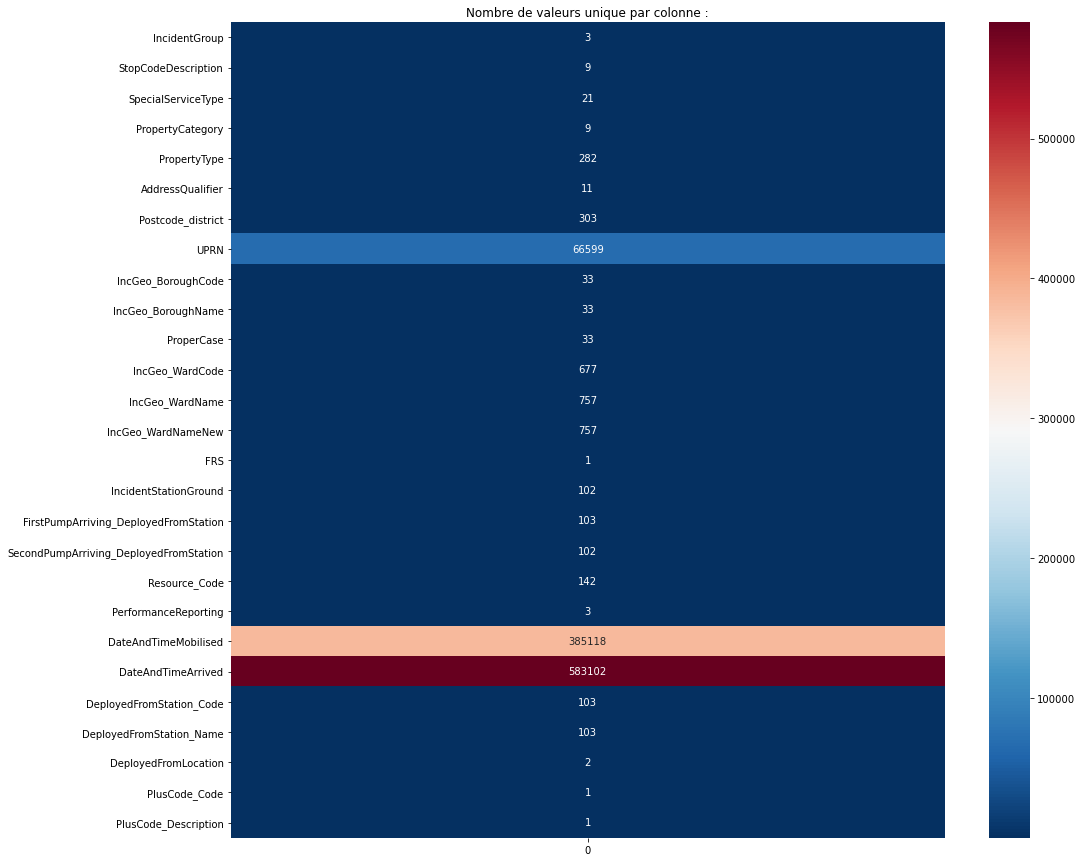

In [38]:
plt.figure(figsize=(16,15))
sns.heatmap(df_categorielle.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')


In [39]:
# Aprés observation de La variable UPRN on constate qu'il existe beaucoup de modalité
# et pour éviter un sur apprentissage sur cette variable et pour uniformiser le modèle 
# d'apprentissage nous préférons supprimer cette variable qui ne représente pas une 
# information importante pour notre objectif
df_categorielle = df_categorielle.drop("UPRN", axis = 1)

print(df_categorielle["IncGeo_WardName"].value_counts())
print(df_categorielle["IncGeo_WardNameNew"].value_counts())

WEST END                  7631
ST. JAMES'S               7268
CHURCH STREET             4373
REGENT'S PARK             4275
LEWISHAM CENTRAL          3843
                          ... 
UPPER NORWOOD                1
FALCONWOOD AND WELLING       1
Eltham South                 1
NUNHEAD                      1
Forest Hill                  1
Name: IncGeo_WardName, Length: 757, dtype: int64
WEST END                  7631
ST. JAMES'S               7268
CHURCH STREET             4373
REGENT'S PARK             4275
LEWISHAM CENTRAL          3843
                          ... 
UPPER NORWOOD                1
FALCONWOOD AND WELLING       1
Eltham South                 1
NUNHEAD                      1
Forest Hill                  1
Name: IncGeo_WardNameNew, Length: 757, dtype: int64


In [40]:
# On constate qu'il existe aussi un décalage du nombre de modalités avec les variables
# IncGeo_WardName, IncGeo_WarNameNew et IncGeo_WardCode
# Nous décidons de garder qu'une seule variable entre IncGeo_WardName et IncGeo_WardNameNew
# On contrôle si il existe des valeurs différentes entre les 2 variables
df_categorielle[df_categorielle["IncGeo_WardName"] != df_categorielle["IncGeo_WardNameNew"]]

# Une seule ligne est remontée mais comme on part du principe que la nouvelle valeur sera plus fiable
# donc on décide de supprimer la variable IncGeo_WardName
df_categorielle = df_categorielle.drop("IncGeo_WardName", axis = 1)

In [41]:
print(df_categorielle["IncGeo_WardNameNew"].head())
print(df_categorielle["IncGeo_WardNameNew"].value_counts())
print(df_categorielle["IncGeo_WardCode"].head())
print(df_categorielle["IncGeo_WardCode"].value_counts())

# Aprés analyse on constate qu'il est préférable de garder la variable "IncGeo_WardNameNew" pour une
# meilleure intérprétation des résultats alors que la variable "IncGeo_WardCode" sera moins représentative 
# lors de l'intérprétation de plus celle-ci possède des valeurs manquantes.
df_categorielle = df_categorielle.drop("IncGeo_WardCode", axis = 1)

0    EAST FINCHLEY
1        SANDS END
2        SANDS END
3     STROUD GREEN
4         COLVILLE
Name: IncGeo_WardNameNew, dtype: object
WEST END                  7631
ST. JAMES'S               7268
CHURCH STREET             4373
REGENT'S PARK             4275
LEWISHAM CENTRAL          3843
                          ... 
UPPER NORWOOD                1
FALCONWOOD AND WELLING       1
Eltham South                 1
NUNHEAD                      1
Forest Hill                  1
Name: IncGeo_WardNameNew, Length: 757, dtype: int64
0    E05000049
1    E05000262
2    E05000262
3    E05000279
4    E05009392
Name: IncGeo_WardCode, dtype: object
E05000649    7631
E05000644    7268
E05000634    4373
E05000448    3843
E05000138    3753
             ... 
E05000515       1
E05000076       1
E05000499       1
E05000168       1
E05000166       1
Name: IncGeo_WardCode, Length: 677, dtype: int64


Text(0.5, 1.0, 'Nombre de valeurs unique par colonne :')

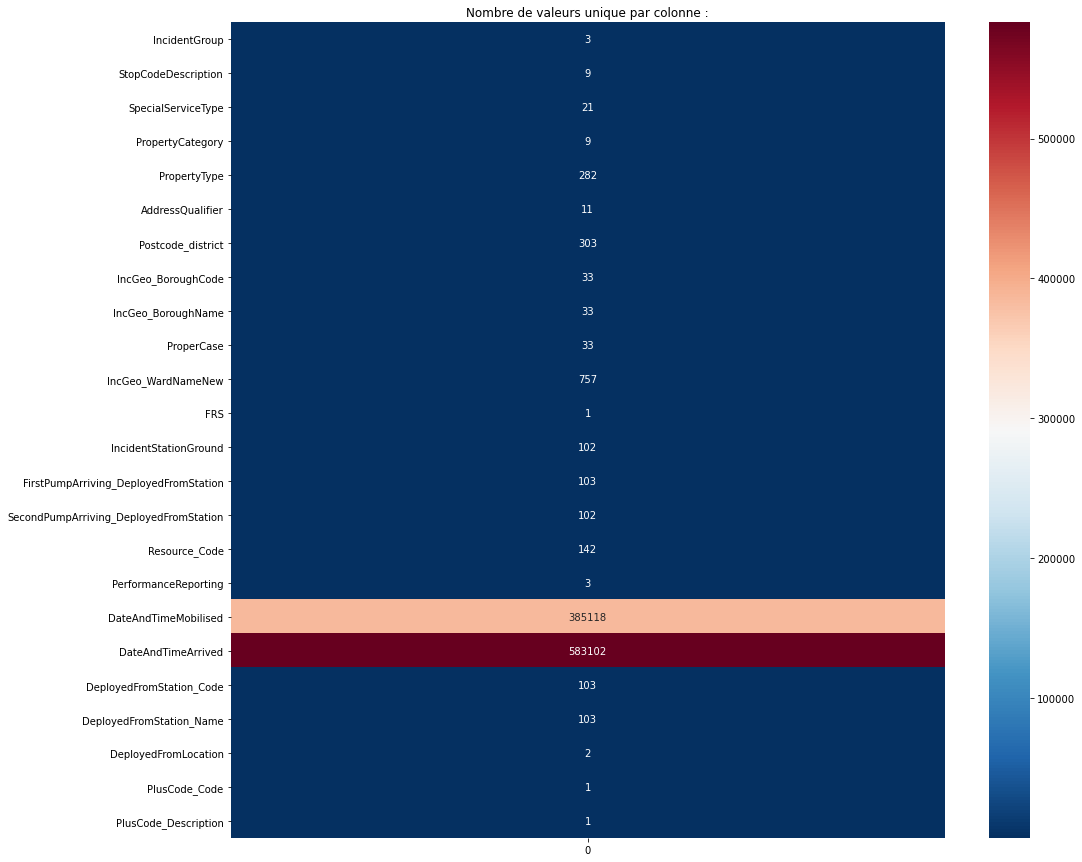

In [42]:
plt.figure(figsize=(16,15))
sns.heatmap(df_categorielle.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')


In [10]:
print(df_categorielle["FRS"].head())
print(df_categorielle["PlusCode_Code"].head())
print(df_categorielle["PlusCode_Description"].head())
print(df_categorielle["FRS"].value_counts())

0    London
1    London
2    London
3    London
4    London
Name: FRS, dtype: object
0    Initial
1    Initial
2    Initial
3    Initial
4    Initial
Name: PlusCode_Code, dtype: object
0    Initial Mobilisation
1    Initial Mobilisation
2    Initial Mobilisation
3    Initial Mobilisation
4    Initial Mobilisation
Name: PlusCode_Description, dtype: object
London    587073
Name: FRS, dtype: int64


In [43]:
# Aprés l'analyse de la heatmap ci-dessus on constate 3 variables qui possède une seule modalité
# "FRS", "PlusCode_Code", "PlusCode_Description" comme celles-ci ne représente pas une information 
# capitale pour l'apprentissage du modèle et qu'il existe qu'une seule modalité donc on decide de les supprimer
df_categorielle = df_categorielle.drop(["FRS", "PlusCode_Code", "PlusCode_Description", "IncidentGroup"], axis = 1)

# On peut constater que la variable "PropertyType" possède beaucoup de modalité comparé aux autres variables
# on essaie d'analyser le contenu de la variable pour déterminer si on la conserve ou pas
print(df_categorielle["PropertyType"].head())
print(df_categorielle["PropertyCategory"].head())
print(df_categorielle["PropertyCategory"].value_counts())
print(df_categorielle["PropertyType"].value_counts())

0                                              Mosque 
1    Purpose Built Flats/Maisonettes - Up to 3 stor...
2    Purpose Built Flats/Maisonettes - Up to 3 stor...
3       Converted Flat/Maisonettes - 3 or more storeys
4       Converted Flat/Maisonettes - 3 or more storeys
Name: PropertyType, dtype: object
0    Non Residential
1           Dwelling
2           Dwelling
3           Dwelling
4           Dwelling
Name: PropertyCategory, dtype: object
Dwelling             339038
Non Residential      106876
Outdoor               39818
Other Residential     39663
Road Vehicle          36814
Outdoor Structure     23299
Rail Vehicle            642
Boat                    493
Aircraft                430
Name: PropertyCategory, dtype: int64
Purpose Built Flats/Maisonettes - 4 to 9 storeys         89496
House - single occupancy                                 70075
Purpose Built Flats/Maisonettes - Up to 3 storeys        59056
Self contained Sheltered Housing                         37269
Purpose

Text(0.5, 1.0, 'Nombre de valeurs unique par colonne :')

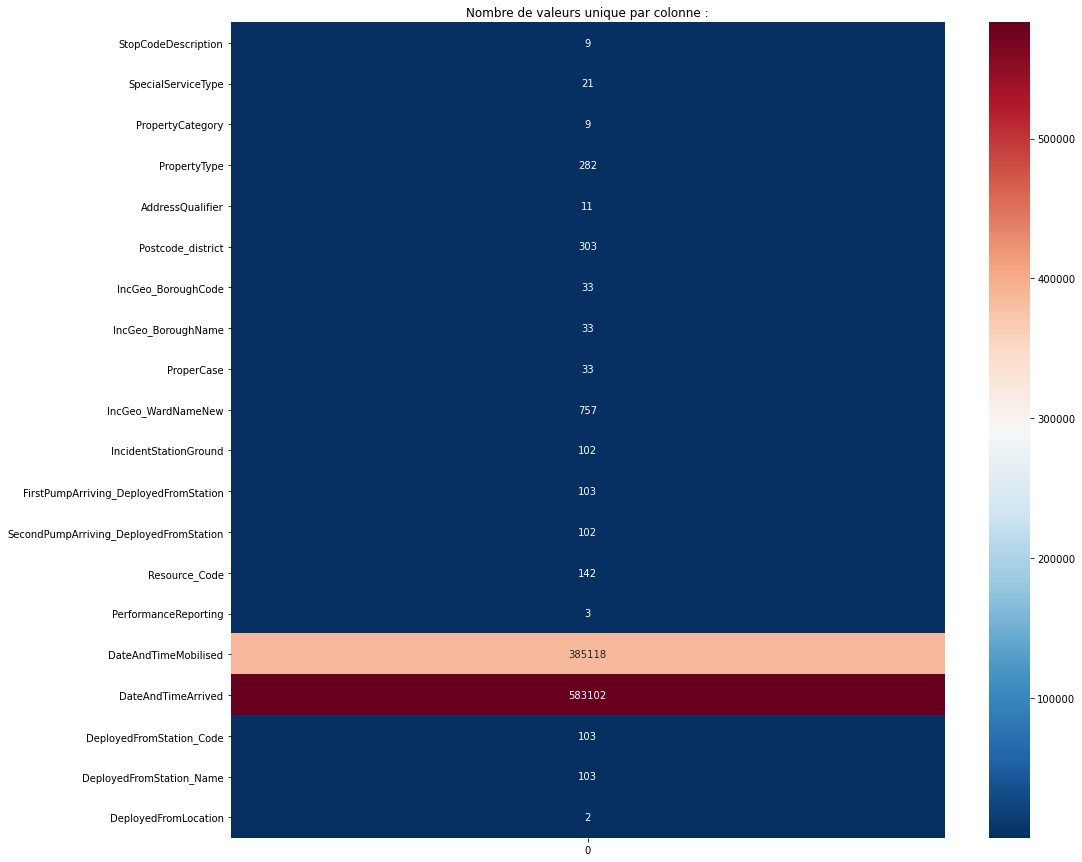

In [12]:
plt.figure(figsize=(16,15))
sns.heatmap(df_categorielle.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')


In [44]:
# On peut voir que l'on peut retrouver l'information similaire avec moins de détail dans la variable "PropertyCategory"
# et de manière à uniformiser le nombre de modalité sur l'ensemble du jeu de données on décide
# de supprimer la variable "PropertyType" 
#df_categorielle = df_categorielle.drop("PropertyType", axis = 1)

df_categorielle['PropertyType'].isna().sum()

# On a plus besoin de la variable "PropertyCategory" qui représente le même type d'information
# que la variable PropertyType mais moins détaillée
df_categorielle = df_categorielle.drop("PropertyCategory", axis = 1)

In [ ]:
print(df_categorielle["SecondPumpArriving_DeployedFromStation"].head())
print(df_categorielle["DeployedFromStation_Code"].head())
print(df_categorielle["Postcode_district"].head())
print(df_categorielle["Resource_Code"].value_counts())

In [45]:
# Il est préférable de conserver dans la plupart des cas l'information littérale plutôt
# qu'un nombre qui n'a pas trop de signification par conséquent on décide de supprimer
# les variables "SecondPumpArriving_DeployedFromStation", "DeployedFromStation_Code", "Postcode_district"
# On décide cependant de conserver le "Resource_Code" qui représente la brigade qui a intervenu pour donner 
# une plus value à l'intérprétation des résultats
df_categorielle = df_categorielle.drop(["SecondPumpArriving_DeployedFromStation", "DeployedFromStation_Code", "Postcode_district"], axis = 1)

df_categorielle.columns

Index(['StopCodeDescription', 'SpecialServiceType', 'PropertyType',
       'AddressQualifier', 'IncGeo_BoroughCode', 'IncGeo_BoroughName',
       'ProperCase', 'IncGeo_WardNameNew', 'IncidentStationGround',
       'FirstPumpArriving_DeployedFromStation', 'Resource_Code',
       'PerformanceReporting', 'DateAndTimeMobilised', 'DateAndTimeArrived',
       'DeployedFromStation_Name', 'DeployedFromLocation'],
      dtype='object')

Text(0.5, 1.0, 'Nombre de valeurs unique par colonne :')

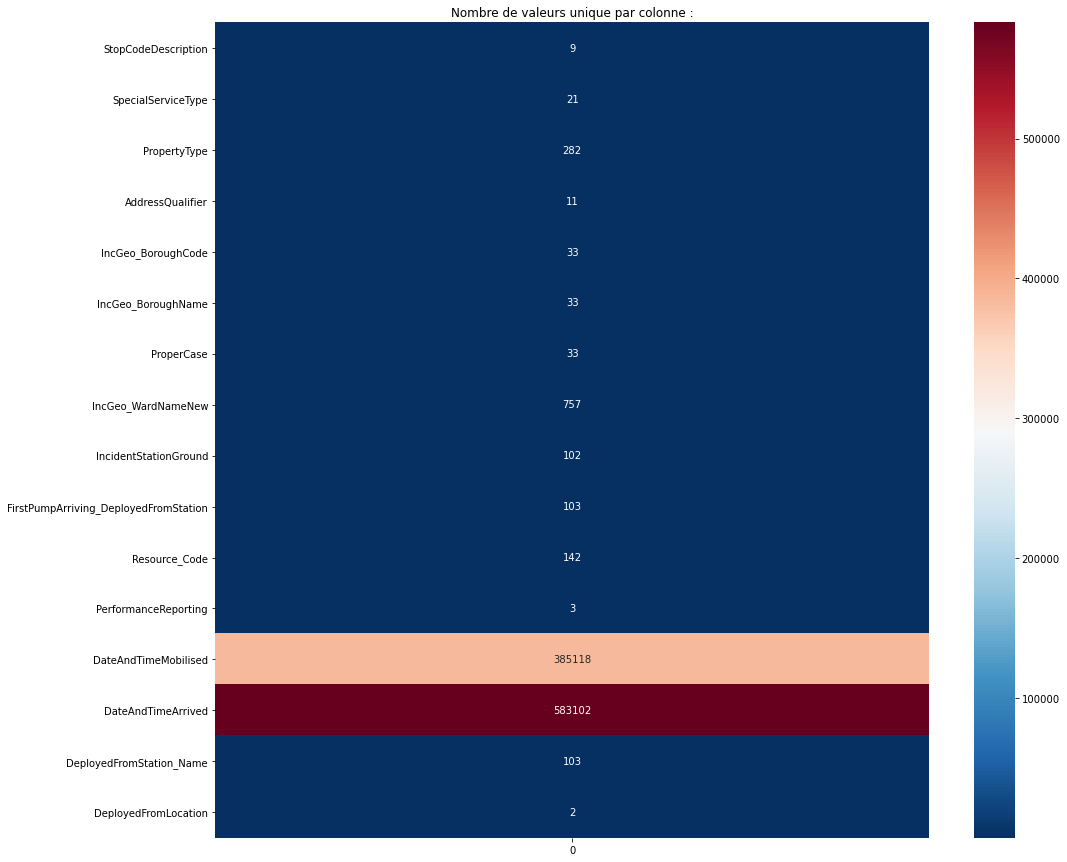

In [46]:
plt.figure(figsize=(16,15))
sns.heatmap(df_categorielle.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')


In [16]:
df_categorielle.head()

print(df_categorielle["DeployedFromLocation"].value_counts())
print(df_categorielle["PerformanceReporting"].value_counts())
print(df_categorielle["PerformanceReporting"].head())

Home Station     565310
Other Station     21427
Name: DeployedFromLocation, dtype: int64
1           375862
2           152067
Not Used     59144
Name: PerformanceReporting, dtype: int64
0    1
1    1
2    2
3    1
4    1
Name: PerformanceReporting, dtype: object


In [47]:
# On décide de transformer la variable "DeployedFromLocation" en variable indicatrice au regard de la répartition
# des modalités ci-dessus
df_categorielle["DeployedFromLocation"] = df_categorielle["DeployedFromLocation"].replace(["Home Station", "Other Station"], [0,1])

# On remplace la valeur "Not Used" par 0
df_categorielle["PerformanceReporting"] = df_categorielle["PerformanceReporting"].replace({"Not Used" : 0})

In [48]:
# Il existe une redondance d'information avec l'arrondissement où l'incident à eu lieu entre les variables
# "IncGeo_BoroughName", "ProperCase" et comme le code de l'arrondissement ne signifie pas
# une information capitale pour l'intérprétation finale on décide de le supprimer pour ne garder que la variable 
# "ProperCase"
df_categorielle = df_categorielle.drop(["IncGeo_BoroughName", "IncGeo_BoroughCode"], axis = 1)

In [49]:
# On remplace les Nans par la modalité de la variable "StopCodeDescription" 
df_categorielle['SpecialServiceType']=df_categorielle['SpecialServiceType'].fillna(df_categorielle['StopCodeDescription'])
df_categorielle.isna().sum()

# On a plus besoin de la variable "StopCodeDescription"
df_categorielle = df_categorielle.drop("StopCodeDescription", axis = 1)

In [50]:
# On déplace les 2 variables "PerformanceReporting" et "DeployedFromLocation" 
# qui sont devenu des variables indicatrices
df_indicatrice["PerformanceReporting"] = df_categorielle["PerformanceReporting"]
df_indicatrice["DeployedFromLocation"] = df_categorielle["DeployedFromLocation"]

# Du coup on peut maintenant les supprimer des variables catégorielles
df_categorielle = df_categorielle.drop(["PerformanceReporting", "DeployedFromLocation"], axis = 1)

Text(0.5, 1.0, 'Nombre de valeurs unique par colonne :')

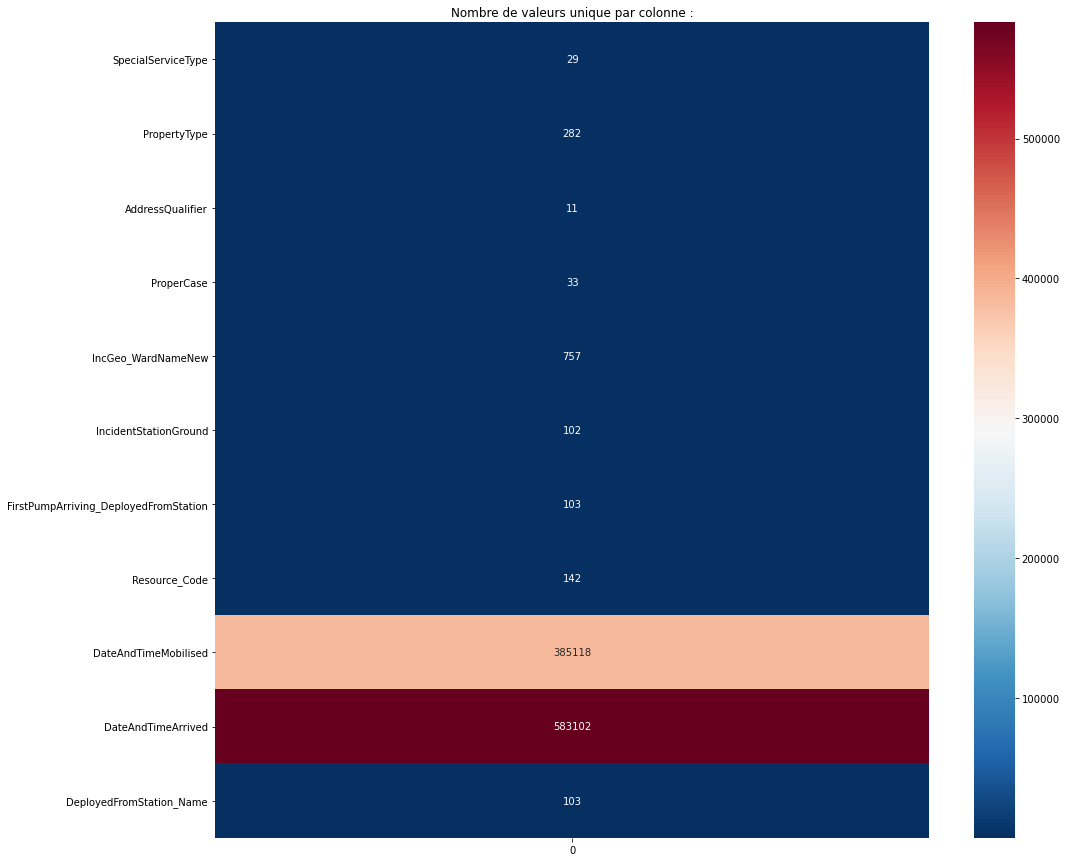

In [20]:
plt.figure(figsize=(16,15))
sns.heatmap(df_categorielle.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')


In [51]:
# On peut voir que les 2 dates "DateAndTimeMobilised" et "DateAndTimeArrived" possèdent un nombre de modalités 
# trop important ce qui va augmenter le nombre de colonnes aprés la discrétisation dons on décident
# de les supprimer
df_categorielle = df_categorielle.drop(["DateAndTimeMobilised", "DateAndTimeArrived"], axis = 1)

In [52]:
# On décident de supprimer la variable "IncGeo_WardNameNew" car on 
# aura un nombre de colonnes trop importants aprés la discrétisation
df_categorielle = df_categorielle.drop(["IncGeo_WardNameNew"], axis = 1)

Text(0.5, 1.0, 'Nombre de valeurs unique par colonne :')

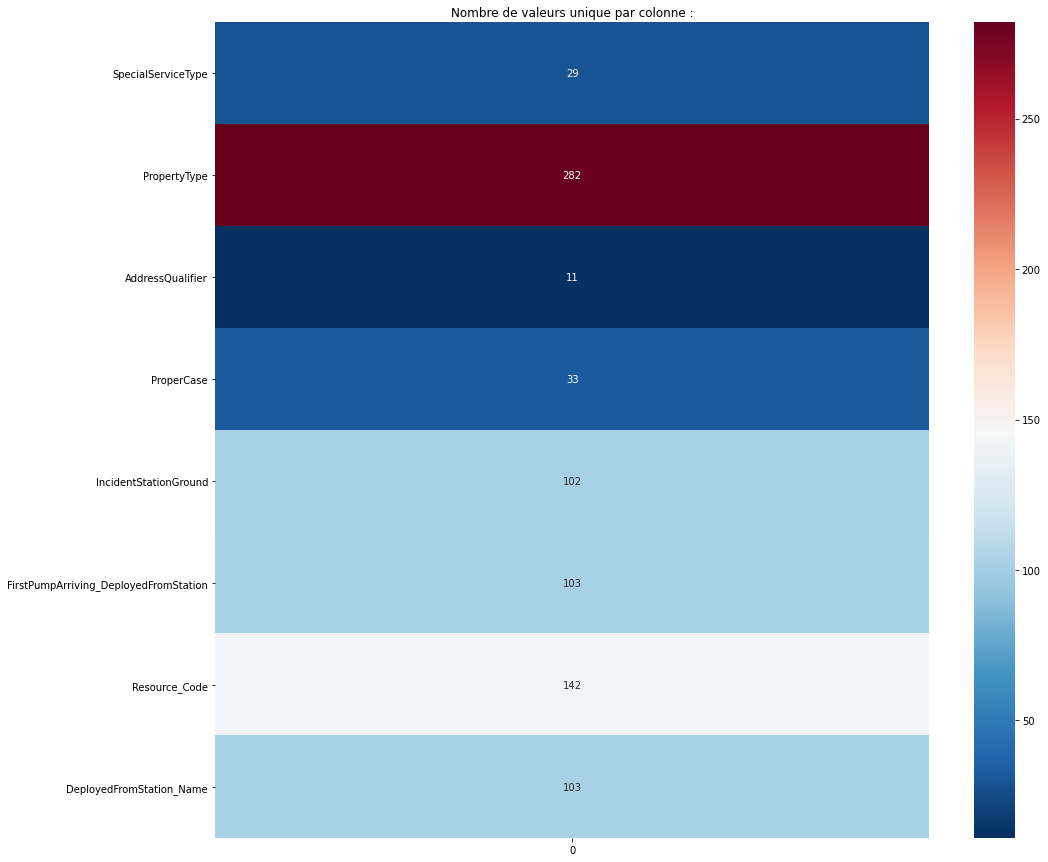

In [39]:
plt.figure(figsize=(16,15))
sns.heatmap(df_categorielle.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')


In [53]:
# On encode les variables catégorielles
df_categ_code = pd.get_dummies(df_categorielle)
df_categ_code.shape

(587073, 805)

In [ ]:
################# VARIABLES INDICATRICES ###################
plt.figure(figsize=(16,15))
sns.heatmap(df_indicatrice.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')

# Pour le pré-processing des variables indicatrices on va supprimer dasn un premier temps les variables 
# qui représente peu d'intérêts pour l'apprentissage du modèle et l'intérprétation du résultat final
# et aussi celles qui n'ont pas de notion métier comme les identifiants

In [24]:
df_indicatrice = df_indicatrice.drop(["USRN", "ResourceMobilisationId"], axis = 1)

In [ ]:
plt.figure(figsize=(16,15))
sns.heatmap(df_indicatrice.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')


In [ ]:
df_indicatrice.head()

In [25]:
df_indicatrice = df_indicatrice.drop(["FirstPumpArriving_AttendanceTime", "SecondPumpArriving_AttendanceTime", "PumpOrder", "Easting_rounded", "Northing_rounded"], axis = 1)


Text(0.5, 1.0, 'Nombre de valeurs unique par colonne :')

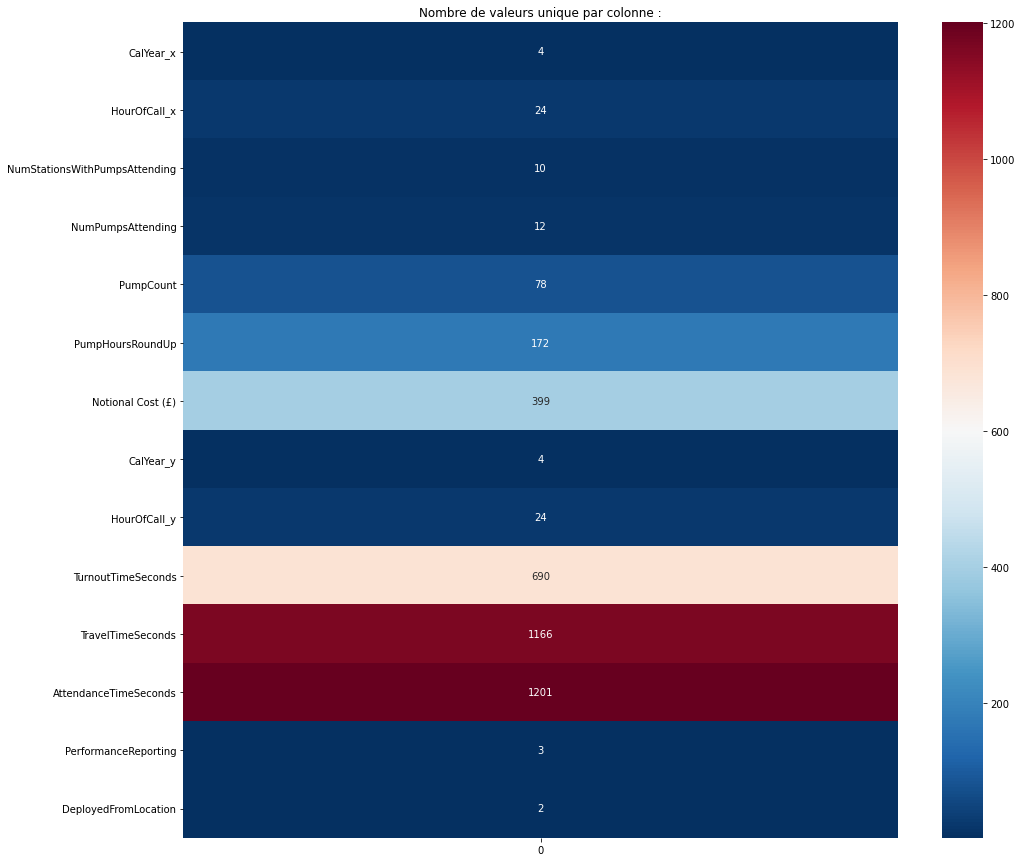

In [26]:
plt.figure(figsize=(16,15))
sns.heatmap(df_indicatrice.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')


In [29]:
print(df_categ_code.isna().sum())
print(df_indicatrice.isna().sum())

SpecialServiceType_AFA                            0
SpecialServiceType_Advice Only                    0
SpecialServiceType_Animal assistance incidents    0
SpecialServiceType_Assist other agencies          0
SpecialServiceType_Chimney Fire                   0
                                                 ..
DeployedFromStation_Name_Whitechapel              0
DeployedFromStation_Name_Willesden                0
DeployedFromStation_Name_Wimbledon                0
DeployedFromStation_Name_Woodford                 0
DeployedFromStation_Name_Woodside                 0
Length: 871, dtype: int64
CalYear_x                           0
HourOfCall_x                        0
NumStationsWithPumpsAttending       0
NumPumpsAttending                   0
PumpCount                           0
PumpHoursRoundUp                  155
Notional Cost (£)                 155
CalYear_y                           0
HourOfCall_y                        0
TurnoutTimeSeconds               3809
TravelTimeSeconds     

In [27]:
# On décide de supprimer les variables "PumpHoursRoundUp" , "Notional Cost (£)", "DeployedFromLocation" 
# qui ne sont pas d'une importance capitale pour l'apprentissage du modèle
df_indicatrice = df_indicatrice.drop(['PumpHoursRoundUp', 'Notional Cost (£)','DeployedFromLocation'], axis = 1)
df_indicatrice.isna().sum()

CalYear_x                           0
HourOfCall_x                        0
NumStationsWithPumpsAttending       0
NumPumpsAttending                   0
PumpCount                           0
CalYear_y                           0
HourOfCall_y                        0
TurnoutTimeSeconds               3809
TravelTimeSeconds                3883
AttendanceTimeSeconds               0
PerformanceReporting                0
dtype: int64

In [28]:
# Les variables 'TurnoutTimeSeconds' et 'TravelTimeSeconds' représente le délai global qui est calculé dans la variable cible
# AttendanceTimeSeconds donc on décident de les supprimer
df_indicatrice = df_indicatrice.drop(['TurnoutTimeSeconds', 'TravelTimeSeconds'], axis = 1)

Text(0.5, 1.0, 'Nombre de valeurs unique par colonne :')

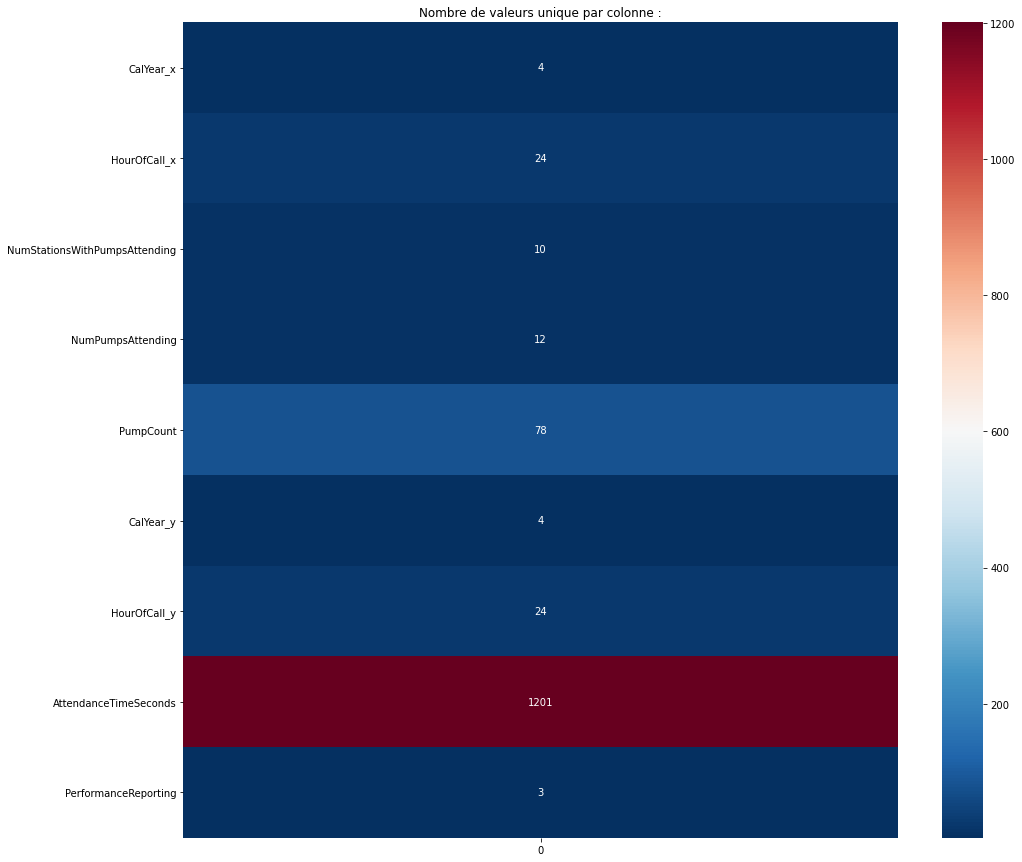

In [29]:
plt.figure(figsize=(16,15))
sns.heatmap(df_indicatrice.nunique().to_frame(),annot=True, cmap='RdBu_r', fmt='d').set_title('Nombre de valeurs unique par colonne :')


In [30]:
df_indicatrice.isna().sum()

CalYear_x                        0
HourOfCall_x                     0
NumStationsWithPumpsAttending    0
NumPumpsAttending                0
PumpCount                        0
CalYear_y                        0
HourOfCall_y                     0
AttendanceTimeSeconds            0
PerformanceReporting             0
dtype: int64

In [54]:
# On merge les 2 datasets
df_merge = pd.concat([df_indicatrice, df_categ_code], axis = 1)

In [55]:
# On vérifie les valeurs Nans
df_merge.isna().sum()

CalYear_x                               0
HourOfCall_x                            0
USRN                                    0
Easting_rounded                         0
Northing_rounded                        0
                                       ..
DeployedFromStation_Name_Whitechapel    0
DeployedFromStation_Name_Willesden      0
DeployedFromStation_Name_Wimbledon      0
DeployedFromStation_Name_Woodford       0
DeployedFromStation_Name_Woodside       0
Length: 826, dtype: int64

In [56]:
# Séparation de la variable cible du reste des autres variables
target = df_merge.AttendanceTimeSeconds
data = df_merge.drop('AttendanceTimeSeconds', axis=1)

# Séparation des données en un ensemble d'apprentissage et un ensemble de Test 
# avec 20% des données originales pour le Test
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=789)

In [64]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train.iloc[:,:11])
X_test_scaled = sc.transform(X_test.iloc[:,:11])

# On vérifie les valeurs Nans
y_train.isna().sum()
y_test.isna().sum()

0

In [ ]:
# Utilisation d'une méthode de réduction de dimensions PCA à voir si on s'en sert ou pas
pca = PCA(n_components = 0.9)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [62]:
# Création d'un modèle de régression linéaire simple pour expliquer le délai en fonction de la variable SpecialServiceType
# à partir de l'ensemble d'entrainement
linearModel = LinearRegression()
linearModel.fit(X_train_scaled, y_train)

# Affchage du score R² et RMSE du modèle sur l'échantillon d'entrainement puis sur celui du test
print('score train :', linearModel.score(X_train_scaled, y_train))
print('score test :', linearModel.score(X_test_scaled, y_test))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').